In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import preprocessing
from scipy import stats

import time
from xgboost.sklearn import XGBClassifier

In [0]:
# Installing featexp will install a lower version of pandas that isn't compatible with colab
# So reinstalling pandas is required
!pip install featexp
import featexp
!pip uninstall pandas
!pip install --upgrade pandas>=0.25.0
import pandas as pd

     |████████████████████████████████| 12.9MB 187kB/s 
     |████████████████████████████████| 13.9MB 172kB/s 
     |████████████████████████████████| 8.9MB 162kB/s 
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=0.25.0; python_version >= "3.0", but you'll have pandas 0.23.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4
  Found existing installation: matplotlib 3.1.2
    Uninstalling matplotlib-3.1.2:
      Successfully uninstalled matplotlib-3.1.2
  Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalle

Uninstalling pandas-0.23.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pandas-0.23.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pandas/*
Proceed (y/n)? 

In [0]:
# TO DOWNLOAD DATASET: Simply get an API key from Kaggle and upload the kaggle.json file

from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!kaggle datasets download -d kemical/kickstarter-projects # api copied from kaggle

!unzip -q kickstarter-projects.zip -d dataset/
os.chdir('dataset')

Saving kaggle.json to kaggle (1).json
kaggle.json
kickstarter-projects.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/ks-projects-201612.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/ks-projects-201801.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
data_original = pd.read_csv('ks-projects-201801.csv', sep=',', engine='python')

In [0]:
data = data_original.copy()

# Data Pre-Processing

In this cell we make necessary adjustments to our data.

The transformations takes the dataset from **378,661 rows and 15 columns** to **373,875 rows and 206 columns**.

The dataset is then split 90% train / 10% test.

In [0]:
################################################################################
##                              PRE - PROCESSING                              ##
################################################################################

# Convert deadline and launched columns to datetime format
data['deadline'] = pd.to_datetime(data['deadline'])
data['launched'] = pd.to_datetime(data['launched'])
data['deadline'] = pd.Series(data['deadline']).dt.round("D")
data['launched'] = pd.Series(data['launched']).dt.round("D")

# Add duration column which is the difference between deadline and launched
data['duration'] = data['deadline'].subtract(data['launched']).dt.days

data.drop(columns=['ID', 'name', 'pledged', 'goal', 'usd pledged'], inplace=True)

# Remove campaigns with launch date of 1970-01-01 01:00:00
data.drop(data.loc[data['launched'] == data['launched'].min()].index, inplace=True)

# Reimpute country, 'N,0"', with appropriate country by looking at its currency.
# N.B. in the case of EUR, replace with DE as it is the most frequest EUR country
currToCountry = dict()
currToCountry['GBP'] = 'GB'
currToCountry['USD'] = 'US'
currToCountry['CAD'] = 'CA'
currToCountry['AUD'] = 'AU'
currToCountry['NOK'] = 'NO'
currToCountry['MXN'] = 'MX'
currToCountry['SEK'] = 'SE'
currToCountry['NZD'] = 'NZ'
currToCountry['CHF'] = 'CH'
currToCountry['DKK'] = 'DK'
currToCountry['HKD'] = 'HK'
currToCountry['SGD'] = 'SG'
currToCountry['JPY'] = 'JP'
currToCountry['EUR'] = 'DE'

data['country'] = data['currency'].map(currToCountry)

# Replace 'canceled' and 'suspended' with 'failed'
data['state'].replace(['suspended', 'canceled'], 'failed', inplace=True)

# Drop rows that have 'live' state
data = data.drop(data.loc[(data['state'] == 'live')].index)

# Reimpute rows with 'undefined' state with 'successful' if pledged amount exceeded
# goal amount or 'failed' otherwise
data.loc[(data['state'] == 'undefined') & (data['usd_pledged_real'] < data['usd_goal_real']), 'state'] = 'failed'
data.loc[(data['state'] == 'undefined') & (data['usd_pledged_real'] >= data['usd_goal_real']), 'state'] = 'successful'

# Drop rows where pledged amount exceeds goal amount, but state is not successful
data.drop(data.loc[(data['usd_pledged_real'] == data['usd_goal_real']) & ~(data['state'] == 'successful')].index, inplace=True)

# Drop backers and usd_pledged_real
data.drop(columns = ['backers', 'usd_pledged_real'], inplace = True)

# Drop duplicate rows
data = data.drop(data[data.duplicated()].index)

# Convert launched and deadline dates to day of the years. Discard year as it's not useful to answer our question
data['launched_dayofyear'] = data['launched'].dt.dayofyear
data['deadline_dayofyear'] = data['deadline'].dt.dayofyear
# data.drop(columns = ['launched', 'deadline'], inplace = True)

# One hot encoding of state
data['state'].replace('failed', 0, inplace=True)
data['state'].replace('successful', 1, inplace=True)

################################################################################
##                     DATASET THAT USES INTEGER ENCODING                     ##
################################################################################

# deep copy of the dataframe to experiment with different methods (won't be necessary for final submission)
df = data.copy()

# convert non-numeric features
df.category = pd.Categorical(df.category)
df.main_category = pd.Categorical(df.main_category)
df.currency = pd.Categorical(df.currency)
df.country = pd.Categorical(df.country)

df = df.assign(category=df.category.cat.codes, main_category=df.main_category.cat.codes, currency=df.currency.cat.codes, country=df.country.cat.codes)

# define X and y
y = df.pop('state')
X = df

# create test set and train set
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.1, random_state=0)

# Copy of train/test to be used with featexp
X2_train = X_train_df.copy()
X2_train['state'] = y_train_df
X2_train.drop(columns=['launched', 'deadline'], inplace=True)

X2_test = X_test_df.copy()
X2_test['state'] = y_test_df
X2_test.drop(columns=['launched', 'deadline'], inplace=True)


################################################################################
##                     DATASET THAT USES ONE-HOT ENCODING                     ##
################################################################################

# One-hot encode categorical features
df1 = pd.get_dummies(data)

y1 = df1.pop('state')
X1 = df1

# create test set and train set
X_train_df1, X_test_df1, y_train_df1, y_test_df1 = train_test_split(X1, y1, test_size=0.1, random_state=0)

n_features1 = X_train_df1.shape[1]

w = np.zeros((1, n_features1))

# turn dataframe to np array
X_train1 = X_train_df1.values
X_test1 = X_test_df1.values

y_train1 = y_train_df1.values
y_test1 = y_test_df1.values

m_train1 = X_train_df1.shape[0]
m_test1 = X_test_df1.shape[0]




# Exploratory Data Analysis

In [0]:
################################################################################
##                          DATA VIZ HELPER METHODS                           ##
################################################################################

def render_stacked_bar(data1, data2, x_ticks, y_label, title):
  n = len(data1)
  width = 0.35
  x_coords = np.arange(n)

  p1 = plt.bar(x_coords, data1, width)
  p2 = plt.bar(x_coords, data2, width, bottom=data1)

  plt.ylabel(y_label)
  plt.title(title)
  plt.xticks(x_coords, x_ticks, rotation='vertical')

  plt.legend((p1[0], p2[0]), ('Successful', 'Failed'))

  plt.show()

def render_main_category_pie(main_cat, n_success, n_failed, left, bottom, w, h):
  labels = 'Successful', 'Failed'
  sizes = [n_success, n_failed]

  ax = fig.add_axes([left, bottom, w, h], aspect=1)
  ax.pie(sizes, labels=labels, radius = 1.2, autopct='%1.1f%%', startangle=90)
  ax.set_title(main_cat)
  ax.axis('equal')

def render_line_plot(data, x_ticks, y_label, title):
  n = len(launch_dates)
  x_coords = np.arange(n)

  plt.plot(x_coords, success_launch)
  plt.ylabel(y_label)
  plt.title(title)
  plt.xticks(x_coords, x_ticks, rotation='vertical')
  
  plt.show()

def render_bar_chart(data, xticks, ylabel, title):
  n = len(data)
  width = 0.35
  x_coords = np.arange(n)

  plt.bar(x_coords, data, width)
  plt.ylabel(ylabel)
  plt.xticks(x_coords, xticks, rotation='vertical')
  plt.title(title)
  plt.ylim([0.6,0.7])

  plt.show()

def render_roc_curve(model, X_test, y_test, title):
  y_pred = model.predict_proba(X_test)[:, 1]
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.legend(loc="lower right")
  plt.title(title)
  plt.show()

## Analysis of Main Categories

Most campaigns are related to entertainment and media, with the most popular being Film & Video and Music.

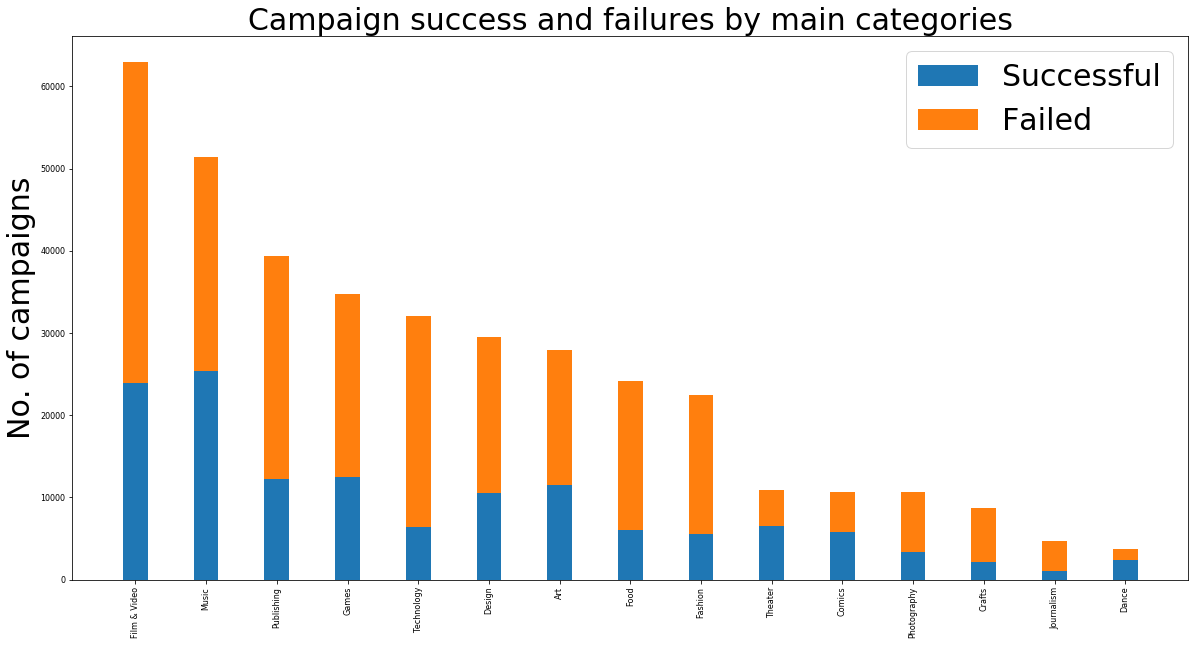

In [0]:
# Campaign success and failures by main categories
# Set font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 18
BIGGER_SIZE = 40

main_cats = data['main_category'].value_counts().index
success_main_cats = []
fail_main_cats = []
plt.rcParams.update({'font.size': BIGGER_SIZE})
for main_cat in main_cats:
  n_success, _ = data.loc[(data['main_category'] == main_cat) & (data['state'] == 1)].shape
  n_fail, _ = data.loc[(data['main_category'] == main_cat) & (data['state'] == 0)].shape
  success_main_cats.append(n_success)
  fail_main_cats.append(n_fail)
plt.figure(figsize=(20,10))
render_stacked_bar(success_main_cats, fail_main_cats, main_cats, 'No. of campaigns', 'Campaign success and failures by main categories')

Within each category, Dance and Theatre have the highest rates of success, whilst Technology and Journalism have the lowest rates of success.

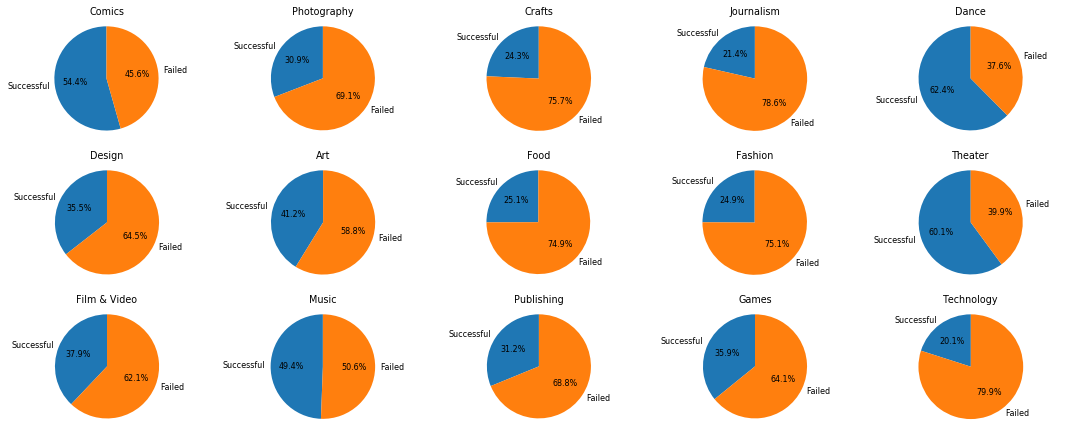

In [0]:
# Proportions of success and failure by main categories
fig = plt.figure()
plt.rcParams.update({'font.size': SMALL_SIZE})
for i, cat in enumerate(main_cats):
  n_success, _ = data.loc[(data['state'] == 1) & (data['main_category'] == cat)].shape
  n_failed,  _ = data.loc[(data['state'] == 0) & (data['main_category'] == cat)].shape

  left = (i % 5) * 0.5

  if i < 5:
    bottom = 0
  elif i < 10:
    bottom = 0.5
  else:
    bottom = 1.0

  render_main_category_pie(cat, n_success, n_failed, left, bottom, 0.4, 0.4)

plt.show()

## Analysis of Campaign Duration

A huge majority of campaigns last 29 or 30 days (the default setting), with a small handful lasting 60 days.

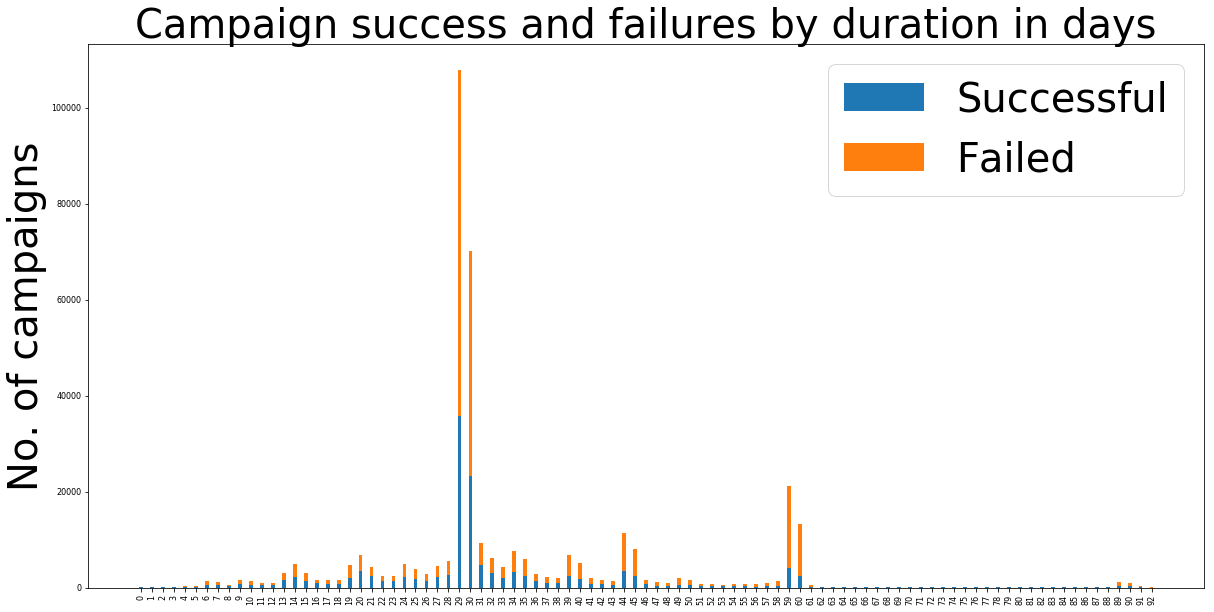

In [0]:
# Campaign success and failures by duration
durations = np.sort(data['duration'].unique())
success_durations = []
fail_durations = []
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
for duration in durations:
  n_success, _ = data.loc[(data['duration'] == duration) & (data['state'] == 1)].shape
  n_fail, _ = data.loc[(data['duration'] == duration) & (data['state'] == 0)].shape
  success_durations.append(n_success)
  fail_durations.append(n_fail)
plt.figure(figsize=(20,10))
render_stacked_bar(success_durations, fail_durations, durations, 'No. of campaigns', 'Campaign success and failures by duration in days')

## Analysis of Countries

The US is the leading contributor of Kickstarter projects.

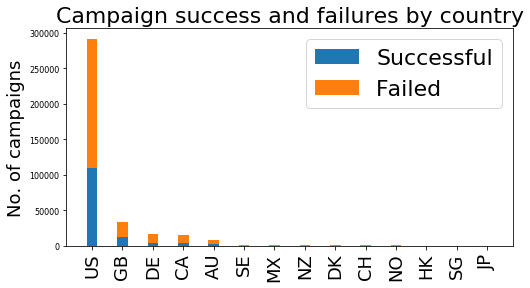

In [0]:
# Campaign success and failures by country
countries = data['country'].value_counts().index
success_countries = []
fail_countries = []

plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
for country in countries:
  n_success, _ = data.loc[(data['country'] == country) & (data['state'] == 1)].shape
  n_fail, _ = data.loc[(data['country'] == country) & (data['state'] == 0)].shape
  success_countries.append(n_success)
  fail_countries.append(n_fail)
plt.figure(figsize=(8,4))
render_stacked_bar(success_countries, fail_countries, countries, 'No. of campaigns', 'Campaign success and failures by country')
  

## Analysis of Launch Date

There was a huge spike in campaigns from latel 2014 to 2015. However, the number of successes have remained relatively stable.

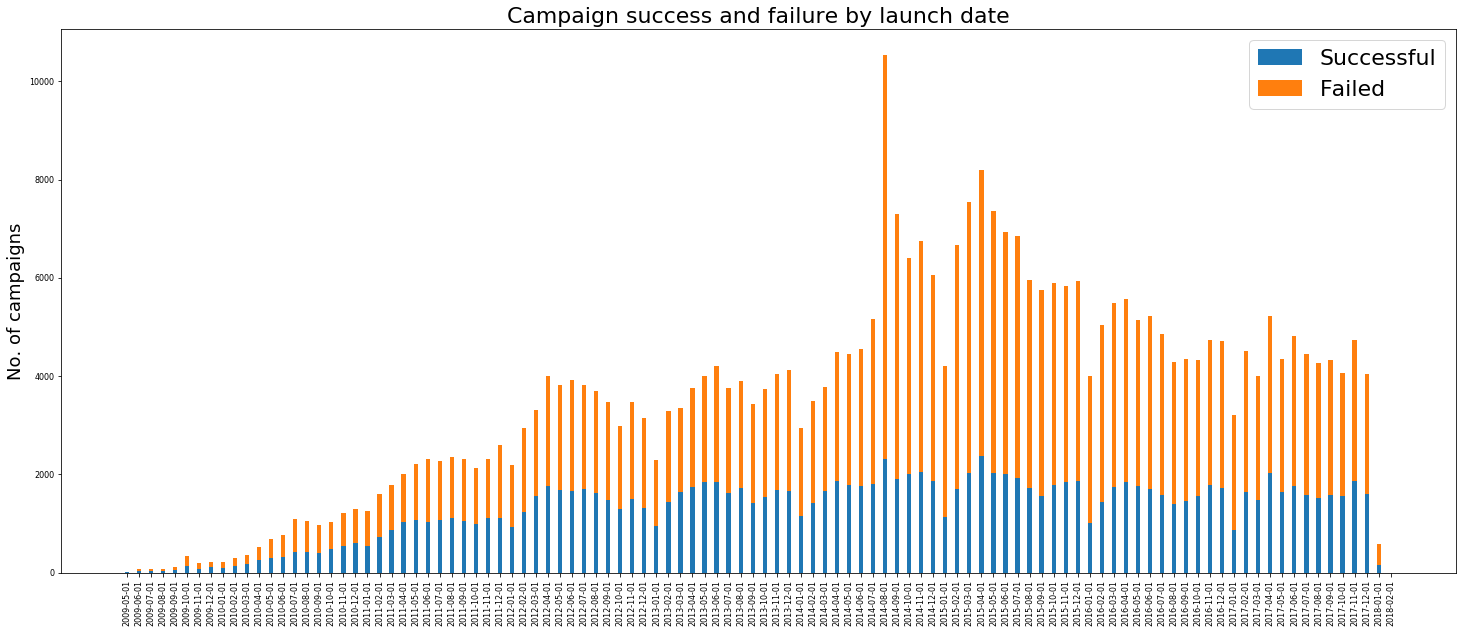

In [0]:
# Campaign success and failure by launch date
data['launched2'] = data['launched'] + pd.offsets.MonthBegin(0)
launch_dates = np.datetime_as_string(np.sort(data['launched2'].unique()), unit='D')
success_launch = []
fail_launch = []
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

for launch_date in launch_dates:
  n_success, _ = data.loc[(data['launched2'] == launch_date) &  (data['state'] == 1)].shape
  n_fail, _    = data.loc[(data['launched2'] == launch_date) & (data['state'] == 0)].shape
  success_launch.append(n_success)
  fail_launch.append(n_fail)

plt.figure(figsize=(25,10))
render_stacked_bar(success_launch, fail_launch, launch_dates, 'No. of campaigns', 'Campaign success and failure by launch date')
data.drop(columns=['launched2', 'launched', 'deadline'], inplace=True)


## Analysis of Goal Amount

As expected, the less money a project asks for, the more likely it is to succeed. The best amount to ask seems to be between \$2,500 to $5,000.

In [0]:
# Campaign success and failure by goal amount

custom_buckets = np.array([0, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 300000, 1000000, data['usd_goal_real'].max()])
data['bucket'] = pd.cut(data['usd_goal_real'], custom_buckets)
buckets = data['bucket'].cat.categories
success_bucket = []
fail_bucket = []
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

for bucket in buckets:
  n_success, _ = data.loc[(data['bucket'] == bucket) &  (data['state'] == 1)].shape
  n_fail   , _ = data.loc[(data['bucket'] == bucket) & (data['state'] == 0)].shape
  success_bucket.append(n_success)
  fail_bucket.append(n_fail)

plt.figure(figsize=(10,5))
render_stacked_bar(success_bucket, fail_bucket, buckets, 'No. of campaigns', 'Campaign success and faiure by USD goal amount')
data.drop(columns=['bucket'], inplace=True)


## Differences between train and test data

Using the featexp package, we followed [this blog post](https://towardsdatascience.com/my-secret-sauce-to-be-in-top-2-of-a-kaggle-competition-57cff0677d3c) to look for noisy features.

                                       Plots for usd_goal_real                                        
                                           Train data plots                                           


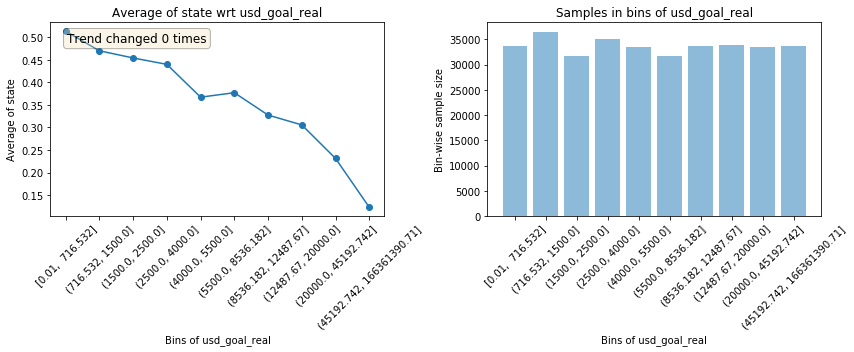

                                           Test data plots                                            


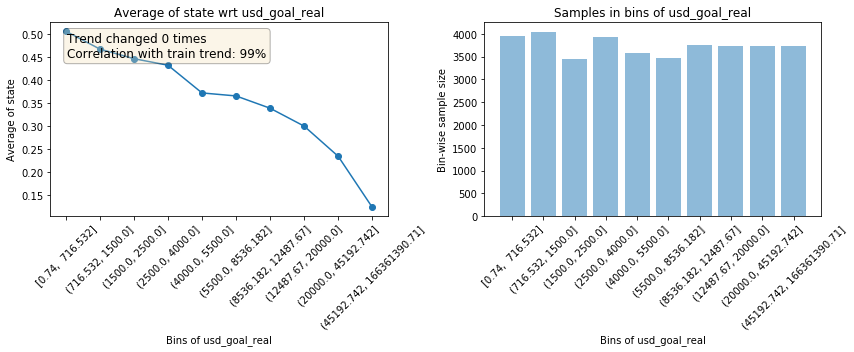

--------------------------------------------------------------------------------------------------------------


                                     Plots for launched_dayofyear                                     
                                           Train data plots                                           


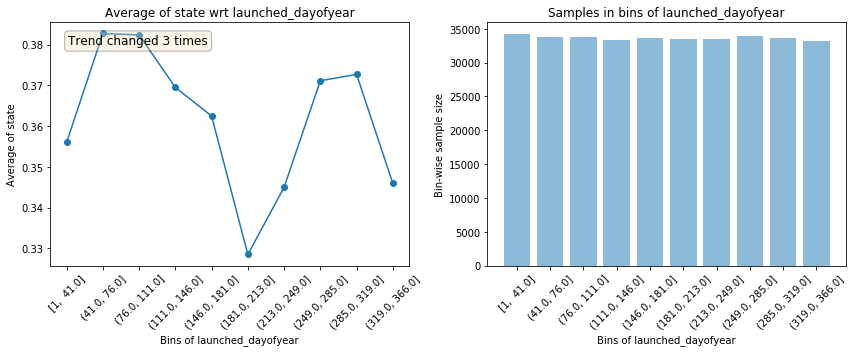

                                           Test data plots                                            


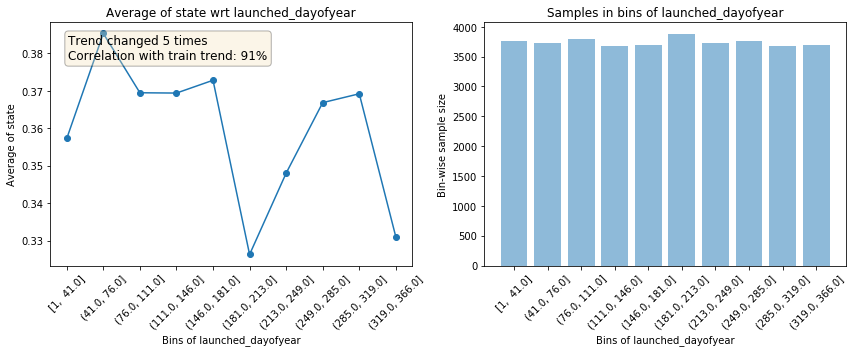

--------------------------------------------------------------------------------------------------------------


                                          Plots for duration                                          
                                           Train data plots                                           


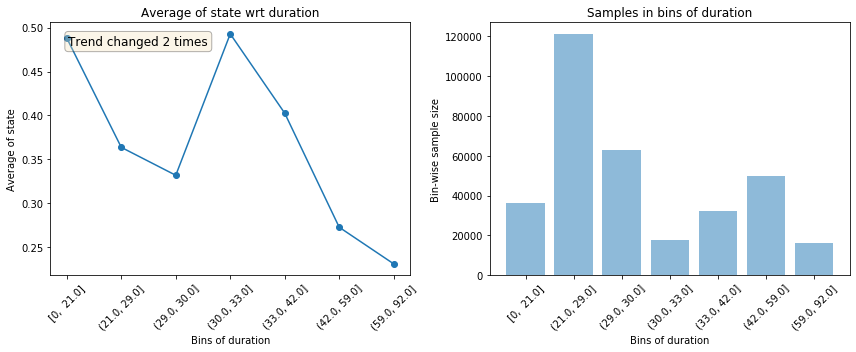

                                           Test data plots                                            


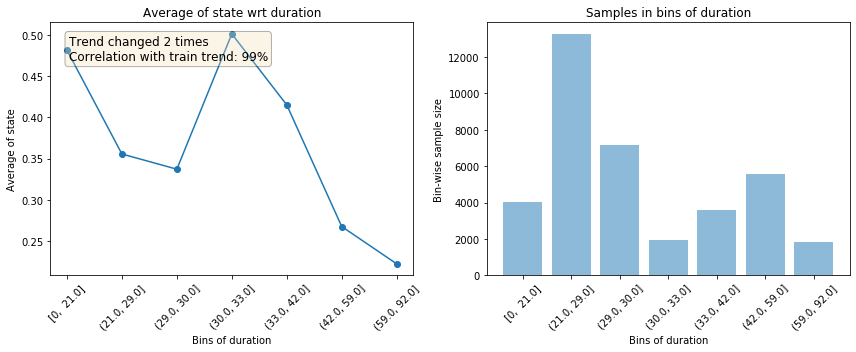

--------------------------------------------------------------------------------------------------------------


                                     Plots for deadline_dayofyear                                     
                                           Train data plots                                           


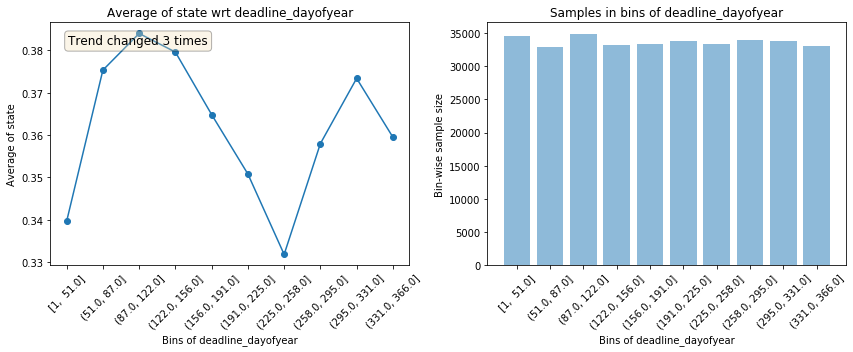

                                           Test data plots                                            


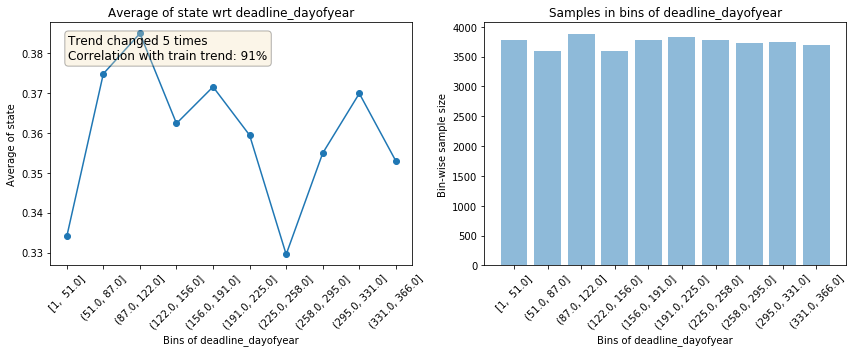

--------------------------------------------------------------------------------------------------------------


                                          Plots for currency                                          
                                           Train data plots                                           


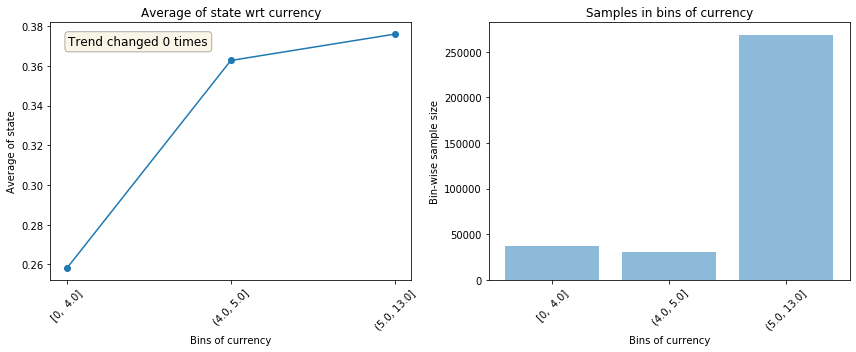

                                           Test data plots                                            


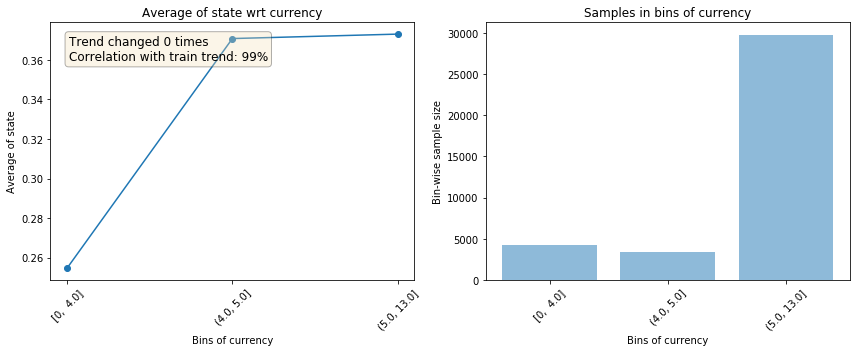

--------------------------------------------------------------------------------------------------------------


                                          Plots for category                                          
                                           Train data plots                                           


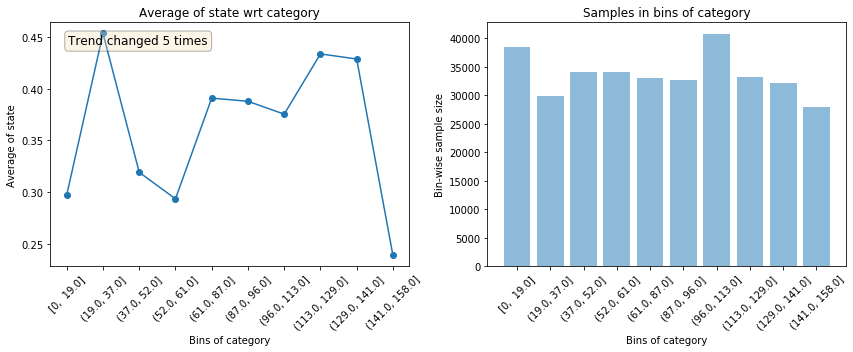

                                           Test data plots                                            


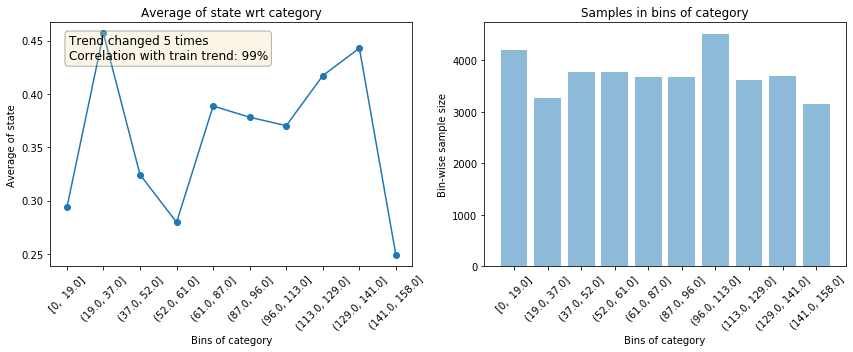

--------------------------------------------------------------------------------------------------------------


                                       Plots for main_category                                        
                                           Train data plots                                           


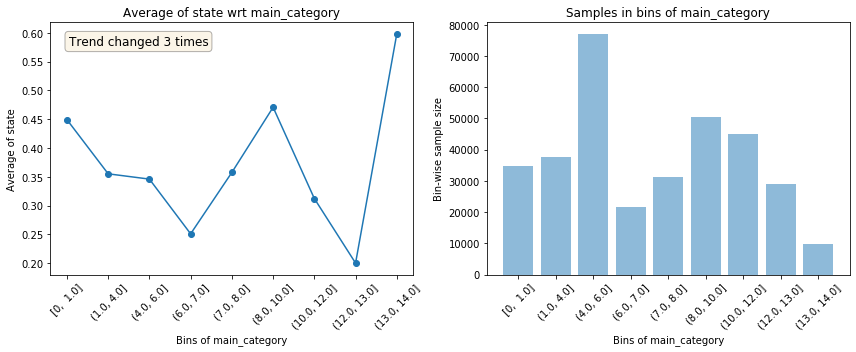

                                           Test data plots                                            


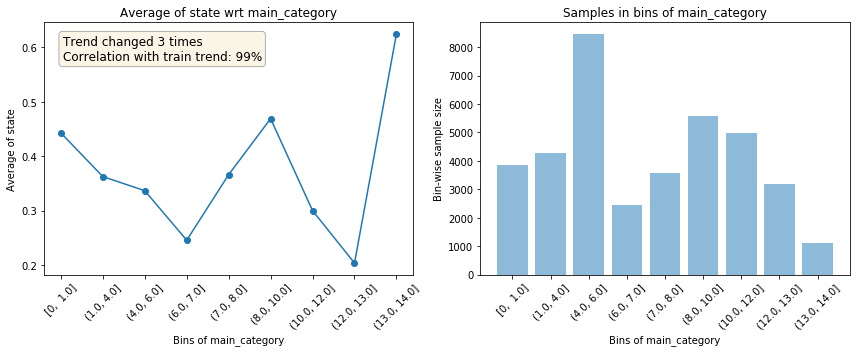

--------------------------------------------------------------------------------------------------------------




In [0]:
featexp.get_univariate_plots(data=X2_train, target_col='state', data_test=X2_test, features_list=['usd_goal_real', 'launched_dayofyear', 'duration', 'deadline_dayofyear', 'currency', 'category', 'main_category'], bins=10)


In [0]:
featexp.get_trend_stats(data=X2_train, target_col='state', data_test=X2_test)

Returning stats for all numeric features


,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,category,5,5,0.990055
1,main_category,3,3,0.996834
2,currency,0,0,0.996275
3,country,0,0,0.997231
4,usd_goal_real,0,0,0.998524
5,duration,2,2,0.997072
6,launched_dayofyear,3,5,0.918716
7,deadline_dayofyear,3,5,0.913767


# Model Training
In this cell we list out all the models and the parameters we want to train on. Ideally, we'd train on all parameters in one pass using GridSearchCV. However, this is too computationally expensive, so we greedily iterate over parameters one at a time.

In [0]:
# Put all models and parameters into a fat data structure

dt_map = {} # decision tree
lr_map = {} # logistic regressoin
rf_map = {} # random forest
ada_map = {} # AdaBoost
xgb_map = {} # XGBoost
mlp_map = {} # MLP

dt_map['model'] = DecisionTreeClassifier(random_state=1)
dt_map['params'] = {
    'min_samples_split' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
    'min_samples_leaf' : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005],
    'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
} 

rf_map['model'] = RandomForestClassifier(random_state=1)
rf_map['params'] = {
    'min_samples_split' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
    'min_samples_leaf' : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005],
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
}

lr_map['model'] = LogisticRegression(max_iter=1000, solver='saga')
lr_map['params'] = {'penalty':['l1', 'l2'], 'C':[.1,1,10,100,500,1000]}



ada_map['model'] = AdaBoostClassifier(random_state=1)
ada_map['params'] = {'base_estimator' : [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
                                  'learning_rate' : [0.25,0.5,0.75,1]} #TODO: FILL IN

xgb_map['model'] = XGBClassifier(random_state=1)
xgb_map['params'] = {} #TODO: FILL IN

mlp_map['model'] = MLPClassifier(random_state=1, hidden_layer_sizes=(10), max_iter=4000)
mlp_map['params'] = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'alpha':[0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]} #TODO: FILL IN


###K-Fold Cross Validation
Cross validation helper method

In [0]:
def KFoldCV(clf, splits):
    cv = KFold(n_splits=splits)
    scores = []
    for train_indices, test_indices in cv.split(X_train1):
        X_train_cv, X_test_cv = X_train1[train_indices], X_train1[test_indices]
        y_train_cv, y_test_cv = y_train1[train_indices], y_train1[test_indices]
        clf.fit(X_train_cv, y_train_cv)
        y_pred = clf.predict(X_test_cv)
        scores.append(accuracy_score(y_pred, y_test_cv))
    return np.mean(scores)

### Logistic Regression

To tune our hyperparameters, we GridSearchCV for two hyperparamters: penalty and the regularization coefficient.

In [0]:
# vanilla logistic regression, Vanilla Logistic Regression score: 0.6383604743060041
lr_baseline = LogisticRegression(solver='liblinear', max_iter=5000)
acc_score = KFoldCV(lr_baseline, 5)

In [0]:
# optimized logistic regression
# first check l1 vs l2 and some c values
lr_parameters = {'penalty':['l1', 'l2'], 'C':np.linspace(0,2,20)}
lr_best = GridSearchCV(lr_baseline, lr_parameters, scoring='accuracy', n_jobs=-1, verbose=3, cv=5)
lr_best.fit(X_train1, y_train1)
lr_best.best_params_, lr_best.best_score_

#results: ({'C': 0.7368421052631579, 'penalty': 'l1'}, 0.6865822438849298
#so now check 
lr_parameters = {'penalty':['l1'], 'C':np.linspace(0.6,0.8,20)}
lr_best = GridSearchCV(lr_baseline, lr_parameters, scoring='accuracy', n_jobs=-1, verbose=3, cv=5)
lr_best.fit(X_train1, y_train1)
lr_best.best_params_, lr_best.best_score_

# results: ({'C': 0.6631578947368421, 'penalty': 'l1'}, 0.6866803154591714)

In [0]:
#test set performance
y_pred_lr = lr_best.predict(X_test1)
acc_lr = accuracy_score(y_pred_lr, y_test1)
print("Accuracy score of Logistic Regression: {}".format(acc_lr))

conf_mat_lr = confusion_matrix(y_test1, y_pred_lr)
tp_lr = conf_mat_lr[1][1]
fp_lr = conf_mat_lr[0][1]
tn_lr = conf_mat_lr[0][0]
fn_lr = conf_mat_lr[1][0]

f1_lr = f1_score(y_test1, y_pred_lr)

print("Precision = {}".format((tp_lr/(tp_lr+fp_lr))))
print("Recall/Sensitivity (TPR) = {}".format(tp_lr/(tp_lr+fn_lr)))
print("Specificity (TNR) = {}".format(tn_lr/(tn_lr+fp_lr)))
print("FPR = {}".format(fp_lr/(fp_lr+tn_lr)))
print("FNR = {}".format(fn_lr/(fn_lr+tp_lr)))
print("F1 score = {}".format(f1_lr))

render_roc_curve(lr_best, X_test1, y_test1, "ROC curve for optimal Logistic Regression Classifier")

###XGBoost

In [0]:
# basline xgbclassifier: 0.6908260920883916
xgb_baseline = XGBClassifier(objective = 'binary:logistic', tree_method='gpu_hist', predictor='gpu_predictor', random_state=1)
KFoldCV(xgb_baseline, 5)

In [0]:
#randsearchcv
param_dist = {'n_estimators': stats.randint(100, 300),
              'learning_rate': stats.uniform(0.01, 0.3),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': np.linspace(1,7,7),
              'colsample_bytree': stats.uniform(0.3, 0.6),
              'min_child_weight': np.linspace(1,4,4)
             }

best_xgb = RandomizedSearchCV(xgb_baseline, 
                         param_distributions = param_dist,
                         cv = 5,
                         n_iter = 30,
                         scoring = 'accuracy',
                         verbose = 3, 
                         n_jobs = -1)
best_xgb.fit(X_train1, y_train1)
best_xgb.best_params_, best_xgb.best_score_

In [0]:
#test set performance
y_pred_xgb = best_xgb.predict(X_test1)
acc_xgb = accuracy_score(y_pred_xgb, y_test1)
print("Accuracy score of XGBoost: {}".format(acc_xgb))

conf_mat_xgb = confusion_matrix(y_test1, y_pred_xgb)
tp_xgb = conf_mat_xgb[1][1]
fp_xgb = conf_mat_xgb[0][1]
tn_xgb = conf_mat_xgb[0][0]
fn_xgb = conf_mat_xgb[1][0]

f1_xgb = f1_score(y_test1, y_pred_xgb)

print("Precision = {}".format((tp_xgb/(tp_xgb+fp_xgb))))
print("Recall/Sensitivity (TPR) = {}".format(tp_xgb/(tp_xgb+fn_xgb)))
print("Specificity (TNR) = {}".format(tn_xgb/(tn_xgb+fp_xgb)))
print("FPR = {}".format(fp_xgb/(fp_xgb+tn_xgb)))
print("FNR = {}".format(fn_xgb/(fn_xgb+tp_xgb)))
print("F1 score = {}".format(f1_xgb))

render_roc_curve(best_xgb, X_test1, y_test1, "ROC curve for optimal XGBClassifier")

### AdaBoost Training

To tune our hyperparameters, we GridSearchCV one parameter at a time. Once the optimal value has been found, we fixed that parameter to the optimal value for the next parameter to grid search on. The parameters are iterated in this order:



1.   base_estimator
2.   learning_rate



In [0]:
# Iterate through base_estimator
ada_base_params = { 'base_estimator' : [DecisionTreeClassifier(max_depth=1),
                                     DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4),
                                     DecisionTreeClassifier(max_depth=5)]}
adaboost_base = GridSearchCV(ada_map['model'], ada_base_params, n_jobs=-1, verbose=3, return_train_score=True)
adaboost_base.fit(X_train1, y_train1)

render_bar_chart(
    adaboost_base.cv_results_['base_estimator'],
    ada_base_params['base_estimator'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of base_estimator values"
)

In [0]:
# Iterate through learning_rate
ada_lr_params = { 'learning_Rate' : [0.1,0.25,0.5,0.75,1]}
adaboost_lr = GridSearchCV(ada_map['model'], ada_lr_params, n_jobs=-1, verbose=3, return_train_score=True)
adaboost_lr.fit(X_train1, y_train1)

render_bar_chart(
    adaboost_lr.cv_results_['learning_Rate'],
    ada_lr_params['learning_Rate'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of learning_Rate values"
)

In [0]:
### OPTIMAL ADABOOST
opt_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), random_state=1, learning_rate = 0.75)
opt_ada.fit(X_train1, y_train1)

y_pred1_ada = opt_ada.predict(X_test1)
acc_ada = accuracy_score(y_test1, y_pred1_ada)
print("Accuracy score of Adaboost: {}".format(acc_ada))

conf_mat_ada = confusion_matrix(y_test1, y_pred1_ada)
tp_ada = conf_mat_ada[1][1]
fp_ada = conf_mat_ada[0][1]
tn_ada = conf_mat_ada[0][0]
fn_ada = conf_mat_ada[1][0]

f1_ada = f1_score(y_test1, y_pred1_ada)

print("Precision = {}".format((tp_ada/(tp_ada+fp_ada))))
print("Recall/Sensitivity (TPR) = {}".format(tp_ada/(tp_ada+fn_ada)))
print("Specificity (TNR) = {}".format(tn_ada/(tn_ada+fp_ada)))
print("FPR = {}".format(fp_ada/(fp_ada+tn_ada)))
print("FNR = {}".format(fn_ada/(fn_ada+tp_ada)))
print("F1 score = {}".format(f1_ada))

render_roc_curve(opt_ada, X_test1, y_test1, "ROC curve for optimal Adaboost")

### Decision Tree Training

To tune our hyperparameters, we GridSearchCV one parameter at a time. Once the optimal value has been found, we fixed that parameter to the optimal value for the next parameter to grid search on. The parameters are iterated in this order:



1.   min_samples_split
2.   min_samplse_leaf
3.   max_depth
4.   max_features



In [0]:
# Iterate through min_samples_split
split_params = { 'min_samples_split' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05] }
dt_split = GridSearchCV(dt_map['model'], split_params, n_jobs=-1, verbose=3, return_train_score=True)
dt_split.fit(X_train1, y_train1)

render_bar_chart(
    dt_split.cv_results_['mean_test_score'],
    split_params['min_samples_split'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of min_sample_split values"
)

In [0]:
# Iterate through min_samples_leaf
leaf_params = { 'min_samples_leaf' : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005] }
dt_leaf = GridSearchCV(DecisionTreeClassifier(random_state=1, min_samples_split=0.005), leaf_params, n_jobs=-1, verbose=3, return_train_score=True)
dt_leaf.fit(X_train1, y_train1)

render_bar_chart(
    dt_leaf.cv_results_['mean_test_score'],
    leaf_params['min_samples_leaf'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of min_sample_leaf values"
)

In [0]:
# Iterate through max_depth
depth_params = { 'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30] }
dt_depth = GridSearchCV(DecisionTreeClassifier(random_state=1, min_samples_split=0.005, min_samples_leaf=0.0001), depth_params, n_jobs=-1, verbose=3, return_train_score=True)
dt_depth.fit(X_train1, y_train1)

render_bar_chart(
    dt_depth.cv_results_['mean_test_score'],
    depth_params['max_depth'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of max_depth values"
)


In [0]:
# Iterate through max_features
feature_params = { 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] }
dt_features = GridSearchCV(DecisionTreeClassifier(random_state=1, min_samples_split=0.005, min_samples_leaf=0.0001, max_depth=18), feature_params, n_jobs=-1, verbose=3, return_train_score=True)
dt_features.fit(X_train1, y_train1)

render_bar_chart(
    dt_features.cv_results_['mean_test_score'],
    feature_params['max_features'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of max_features values"
)

In [0]:
### OPTIMAL DECISION TREE
opt_dt = DecisionTreeClassifier(random_state=1, min_samples_split=0.005, min_samples_leaf=0.0001, max_depth=18, max_features=0.9)
opt_dt.fit(X_train1, y_train1)

y_pred1_dt = opt_dt.predict(X_test1)
acc_dt = accuracy_score(y_test1, y_pred1_dt)
print("Accuracy score of decision tree: {}".format(acc_dt))

conf_mat_dt = confusion_matrix(y_test1, y_pred1_dt)
tp_dt = conf_mat[1][1]
fp_dt = conf_mat[0][1]
tn_dt = conf_mat[0][0]
fn_dt = conf_mat[1][0]

f1_dt = f1_score(y_test1, y_pred1_dt)

print("Precision = {}".format((tp_dt/(tp_dt+fp_dt))))
print("Recall/Sensitivity (TPR) = {}".format(tp_dt/(tp_dt+fn_dt)))
print("Specificity (TNR) = {}".format(tn_dt/(tn_dt+fp_dt)))
print("FPR = {}".format(fp_dt/(fp_dt+tn_dt)))
print("FNR = {}".format(fn_dt/(fn_dt+tp_dt)))
print("F1 score = {}".format(f1_dt))

render_roc_curve(opt_dt, X_test1, y_test1, "ROC curve for optimal decision tree")

### Random Forest Training

To tune our hyperparameters, we GridSearchCV one parameter at a time. Once the optimal value has been found, we fixed that parameter to the optimal value for the next parameter to grid search on. The parameters are iterated in this order:



1.   min_samples_split
2.   min_samplse_leaf
3.   max_depth
4.   max_features
5.   n_estimators



In [0]:
# Iterate through min_samples_split
split_params = { 'min_samples_split' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05] }
rf_split = GridSearchCV(rf_map['model'], split_params, n_jobs=-1, verbose=3, return_train_score=True)
rf_split.fit(X_train1, y_train1)

render_bar_chart(
    rf_split.cv_results_['mean_test_score'],
    split_params['min_samples_split'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of min_sample_split values"
)

In [0]:
# Iterate through min_samples_leaf
leaf_params = { 'min_samples_leaf' : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005] }
rf_leaf = GridSearchCV(RandomForestClassifier(random_state=1, min_samples_split=0.0005), leaf_params, n_jobs=-1, verbose=3, return_train_score=True)
rf_leaf.fit(X_train1, y_train1)

render_bar_chart(
    rf_leaf.cv_results_['mean_test_score'],
    leaf_params['min_samples_leaf'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of min_sample_leaf values"
)

In [0]:
# Iterate through max_depth
depth_params = { 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100] }
rf_depth = GridSearchCV(RandomForestClassifier(random_state=1, min_samples_split=0.0005, min_samples_leaf=0.00001), depth_params, n_jobs=-1, verbose=3, return_train_score=True)
rf_depth.fit(X_train1, y_train1)

render_bar_chart(
    rf_depth.cv_results_['mean_test_score'],
    depth_params['max_depth'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of max_depth values"
)

In [0]:
# Iterate through max_features
feature_params = { 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] }
rf_features = GridSearchCV(RandomForestClassifier(random_state=1, min_samples_split=0.0005, min_samples_leaf=0.00001, max_depth=100), feature_params, n_jobs=-1, verbose=3, return_train_score=True)
rf_features.fit(X_train1, y_train1)

render_bar_chart(
    rf_features.cv_results_['mean_test_score'],
    feature_params['max_featuers'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of max__features values"
)

In [0]:
# Iterate through n_estimators
estimator_params = { 'n_estimators': [200, 400, 600, 800, 1000] }
rf_estimator = GridSearchCV(RandomForestClassifier(random_state=1, min_samples_split=0.0005, min_samples_leaf=0.00001, max_depth=100, max_features=0.2), estimator_params, n_jobs=-1, verbose=3, return_train_score=True)
rf_estimator.fit(X_train1, y_train1)

render_bar_chart(
    rf_features.cv_results_['mean_test_score'],
    feature_params['n_estimators'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of n_estimators values"
)

In [0]:
### OPTIMAL RANDOM FOREST
opt_rf = DecisionTreeClassifier(random_state=1, min_samples_split=0.0005, min_samples_leaf=0.00001, max_depth=100, max_features=0.2)
opt_rf.fit(X_train1, y_train1)

y_pred1_rf = opt_rf.predict(X_test1)
acc_rf = accuracy_score(y_test1, y_pred1_rf)
print("Accuracy score of decision tree: {}".format(acc_rf))

conf_mat_rf = confusion_matrix(y_test1, y_pred1_rf)
tp_rf = conf_mat[1][1]
fp_rf = conf_mat[0][1]
tn_rf = conf_mat[0][0]
fn_rf = conf_mat[1][0]

f1_rf = f1_score(y_test1, y_pred1_rf)

print("Precision = {}".format((tp_rf/(tp_rf+fp_rf))))
print("Recall/Sensitivity (TPR) = {}".format(tp_rf/(tp_rf+fn_rf)))
print("Specificity (TNR) = {}".format(tn_rf/(tn_rf+fp_rf)))
print("FPR = {}".format(fp_rf/(fp_rf+tn_rf)))
print("FNR = {}".format(fn_rf/(fn_rf+tp_rf)))
print("F1 score = {}".format(f1_rf))

render_roc_curve(opt_rf, X_test1, y_test1, "ROC curve for optimal decision tree")

### Neural Network/MLP Training

To tune our hyperparameters, we GridSearchCV one parameter at a time. Once the optimal value has been found, we fixed that parameter to the optimal value for the next parameter to grid search on. The parameters are iterated in this order:



1.   activation
2.   alpha



In [0]:
# Iterate through activation
mlp_activation_params = { 'activation' : ['identity', 'logistic', 'tanh', 'relu']}
mlp_activation = GridSearchCV(mlp_map['model'], mlp_activation_params, n_jobs=-1, verbose=3, return_train_score=True)
mlp_activation.fit(X_train1, y_train1)

render_bar_chart(
    mlp_activation.cv_results_['activation'],
    mlp_activation_params['activation'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of activation values"
)

In [0]:
# Iterate through alpha
mlp_alpha_params = { 'alpha' : [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]}
mlp_alpha = GridSearchCV(mlp_map['model'], mlp_alpha_params, n_jobs=-1, verbose=3, return_train_score=True)
mlp_alpha.fit(X_train1, y_train1)

render_bar_chart(
    mlp_alpha.cv_results_['alpha'],
    mlp_alpha_params['alpha'],
    "Mean accuracy score",
    "Mean accuracy score across 5-fold CV over a range of alpha values"
)

In [0]:
### OPTIMAL MLP
opt_mlp = MLPClassifier(activation = 'relu', random_state=1, alpha = 0.0001)
opt_mlp.fit(X_train1, y_train1)

y_pred1_mlp = opt_mlp.predict(X_test1)
acc_mlp = accuracy_score(y_test1, y_pred1_mlp)
print("Accuracy score of Adaboost: {}".format(acc_mlp))

conf_mat_mlp = confusion_matrix(y_test1, y_pred1_mlp)
tp_mlp = conf_mat_mlp[1][1]
fp_mlp = conf_mat_mlp[0][1]
tn_mlp = conf_mat_mlp[0][0]
fn_mlp = conf_mat_mlp[1][0]

f1_mlp = f1_score(y_test1, y_pred1_mlp)

print("Precision = {}".format((tp_mlp/(tp_mlp+fp_mlp))))
print("Recall/Sensitivity (TPR) = {}".format(tp_mlp/(tp_mlp+fn_mlp)))
print("Specificity (TNR) = {}".format(tn_mlp/(tn_mlp+fp_mlp)))
print("FPR = {}".format(fp_mlp/(fp_mlp+tn_mlp)))
print("FNR = {}".format(fn_mlp/(fn_mlp+tp_mlp)))
print("F1 score = {}".format(f1_mlp))

render_roc_curve(opt_mlp, X_test1, y_test1, "ROC curve for optimal MLP")